# Dense model


(32, 224, 224, 3) (32,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,149,184 (23.46 MB)

 Non-trainable params: 888,320 (3.39 MB)

Epoch 1/20


I0000 00:00:1734469393.155308      75 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_2', 8 bytes spill stores, 8 bytes spill loads



121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3121 - loss: 2.1433

I0000 00:00:1734469468.293315      77 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_69', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_2', 8 bytes spill stores, 8 bytes spill loads



122/122 ━━━━━━━━━━━━━━━━━━━━ 198s 750ms/step - accuracy: 0.3132 - loss: 2.1357 - val_accuracy: 0.4843 - val_loss: 1.2504
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.5713 - loss: 1.0659 - val_accuracy: 0.6906 - val_loss: 0.8183
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.7231 - loss: 0.7214 - val_accuracy: 0.7643 - val_loss: 0.6441
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.7901 - loss: 0.5510 - val_accuracy: 0.7937 - val_loss: 0.5442
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.8565 - loss: 0.4022 - val_accuracy: 0.8343 - val_loss: 0.4679
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.8748 - loss: 0.3372 - val_accuracy: 0.8490 - val_loss: 0.4385
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9139 - loss: 0.2574 - val_accuracy: 0.8692 - val_loss: 0.3780
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9378 - loss: 0.1886 - va

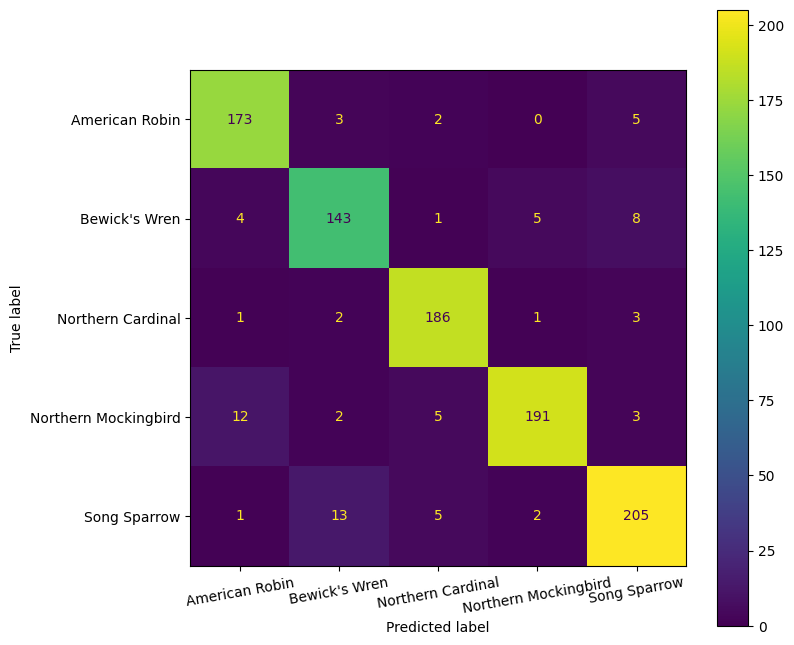

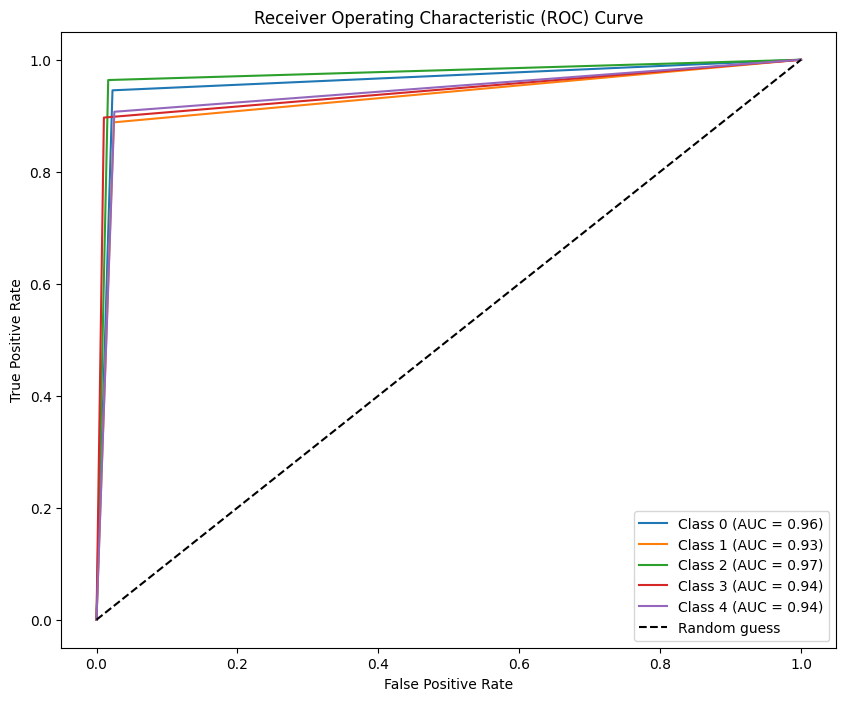

In [18]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the directory of your audio files
wavefiles_dir = '/kaggle/input/bird-song-data-set/wavfiles/'

# Assuming df contains your metadata with 'filename' and 'name' columns
df = pd.read_csv("/kaggle/input/bird-song-data-set/bird_songs_metadata.csv")
df['filename'] = np.squeeze(df['filename'])

# Convert labels to numerical values (this is for multi-class classification)
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['name'])

# Create filepaths
filepaths = np.array([os.path.join(wavefiles_dir, file) for file in df['filename']])
labels = df['labels'].values

# Split the data into train, validation, and test sets (70% train, 10% validation, 20% test)
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(filepaths, labels, test_size=0.1, random_state=45, stratify=labels)
train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(train_filepaths, train_labels, test_size=0.2, random_state=45, stratify=train_labels)

# Function to load and process audio files into Mel spectrograms
def process_audio(audio_file):
    # Load audio file using librosa
    y, sr = librosa.load(audio_file, duration=10)  # Duration of 10 seconds
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibel scale
    
    # Add a channel dimension to simulate a single-channel image
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # Shape becomes (height, width, 1)
    
    # Resize spectrogram to a fixed size (224, 224) for the model
    mel_spec_resized = image.smart_resize(mel_spec, size=(224, 224))  # Resize spectrograms to (224, 224)
    
    # Replicate the single channel to 3 channels (for model input)
    mel_spec_resized = np.repeat(mel_spec_resized, 3, axis=-1)  # Shape becomes (224, 224, 3)
    
    return mel_spec_resized

# Function to create dataset from filepaths and labels
def make_dataset(labels, filepaths, shuffle):
    # List to store spectrograms and labels
    spectrograms = []
    for i in range(len(filepaths)):
        mel_spec = process_audio(filepaths[i])  # Process the audio file into Mel Spectrogram
        spectrograms.append(mel_spec)
    
    # Convert the spectrograms and labels to numpy arrays
    spectrograms = np.array(spectrograms)
    labels = np.array(labels)
    
    # Convert to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((spectrograms, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(filepaths), reshuffle_each_iteration=True)
    
    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create the train, validation, and test datasets
train_dataset = make_dataset(train_labels, train_filepaths, shuffle=True)
val_dataset = make_dataset(val_labels, val_filepaths, shuffle=False)
test_dataset = make_dataset(test_labels, test_filepaths, shuffle=False)

# Example: Inspect the first batch from the train dataset
for mel_spec, label in train_dataset.take(1):
    print(mel_spec.shape, label.shape)

# Create DenseNet121 Model with Fine-Tuning
def create_densenet121_model(input_shape=(224, 224, 3), num_classes=5, fine_tune_at=100):
    # Load the DenseNet121 model without the top classification layer
    base_model = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Unfreeze layers starting from `fine_tune_at`
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  # Freeze layers before `fine_tune_at`

    model = Sequential()
    model.add(base_model)  # Add the base model
    model.add(Flatten())  # Flatten the output from the base model
    model.add(Dense(128, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

    return model

# Create and compile the model
model = create_densenet121_model(input_shape=(224, 224, 3), num_classes=5, fine_tune_at=100)
model.summary()  # Check the updated model structure

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Callbacks for saving the best model
checkpoint_cb = ModelCheckpoint("densenet121_model_finetuned.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with the training and validation datasets
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

# Load the best model
model.load_weights("densenet121_model_finetuned.keras")

# Evaluate the model on the test set
model.evaluate(test_dataset)

# Predict the test set
pred_y = model.predict(test_dataset)
pred_y = np.argmax(pred_y, axis=1)

# Confusion matrix and visualization
import sklearn.metrics
confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, pred_y)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=label_encoder.classes_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(8, 8))
confusion_matrix_display.plot(ax=ax, xticks_rotation=10)

# Compute and plot F1 Score and ROC curves
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC
true_y_bin = label_binarize(test_labels, classes=np.arange(5))
pred_y_bin = label_binarize(pred_y, classes=np.arange(5))

# Calculate F1 score
f1 = f1_score(true_y_bin, pred_y_bin, average='macro')
print(f'F1 Score: {f1}')

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(true_y_bin[:, i], pred_y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Xception model


Batch shape: (32, 224, 224, 3), Label shape: (32,)
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 9,478,344 (36.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 257ms/step - accuracy: 0.3844 - loss: 1.4219 - val_accuracy: 0.4512 - val_loss: 1.3298
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.5983 - loss: 1.0060 - val_accuracy: 0.6151 - val_loss: 1.0838
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.6960 - loss: 0.7912 - val_accuracy: 0.7422 - val_loss: 0.8435
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.7839 - loss: 0.6183 - val_accuracy: 0.7735 - val_loss: 0.6176
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.8156 - loss: 0.5361 - val_accuracy: 0.7864 - val_loss: 0.5863
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.8464 - loss: 0.4408 - val_accuracy: 0.8324 - val_loss: 0.4910
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.8701 - loss: 0.3739 - val_accuracy: 0.8490 - val_loss: 0.4309
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.8925 - loss: 0

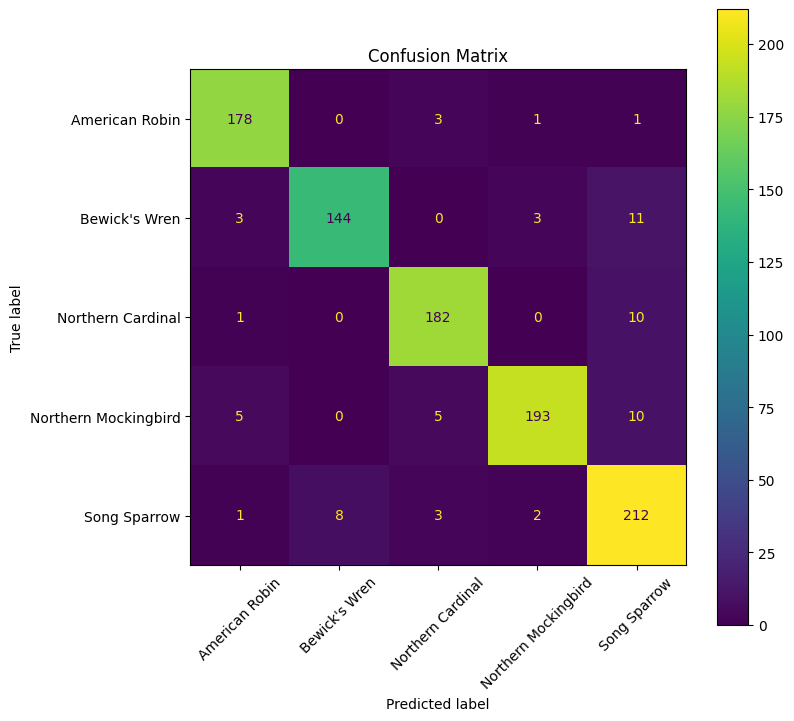

F1 Score: 0.9323


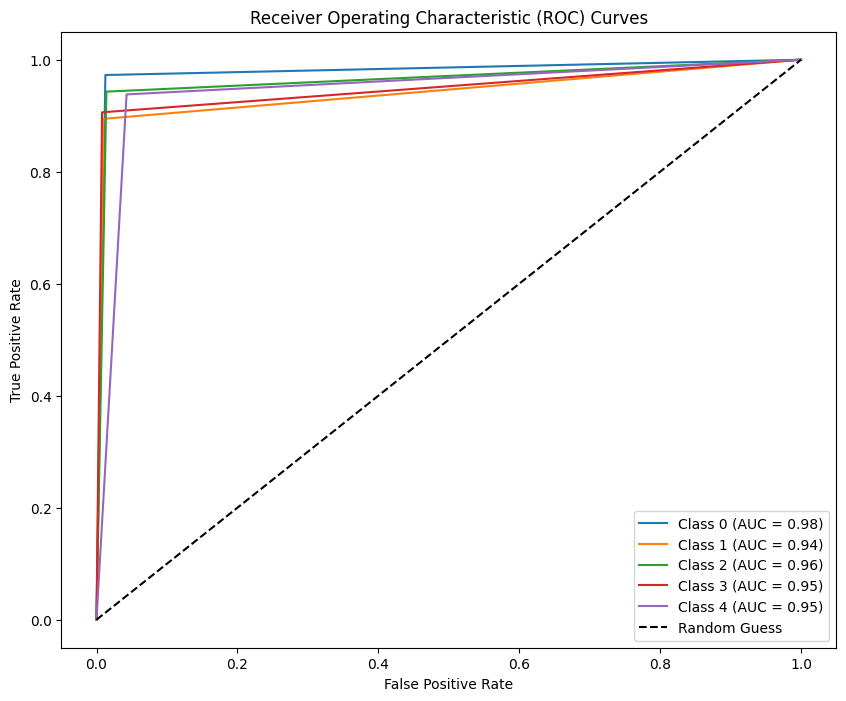

In [19]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import librosa
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import Xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define the directory of your audio files
wavefiles_dir = '/kaggle/input/bird-song-data-set/wavfiles/'

# Load metadata containing 'filename' and 'name' columns
df = pd.read_csv("/kaggle/input/bird-song-data-set/bird_songs_metadata.csv")
df['filename'] = np.squeeze(df['filename'])

# Encode labels to numerical values (for multi-class classification)
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['name'])

# Create filepaths and labels arrays
filepaths = np.array([os.path.join(wavefiles_dir, file) for file in df['filename']])
labels = df['labels'].values

# Split the data into train, validation, and test sets
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.1, random_state=45, stratify=labels
)
train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    train_filepaths, train_labels, test_size=0.2, random_state=45, stratify=train_labels
)

# Function to process audio into Mel spectrograms
def process_audio(audio_file):
    # Load audio file using librosa
    y, sr = librosa.load(audio_file, duration=10)  # Duration of 10 seconds
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibel scale

    # Add a channel dimension to simulate an image format
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # Shape: (height, width, 1)

    # Resize spectrogram to a fixed size (224, 224) for Xception
    mel_spec_resized = image.smart_resize(mel_spec, size=(224, 224))

    # Replicate the single channel to 3 channels
    mel_spec_resized = np.repeat(mel_spec_resized, 3, axis=-1)  # Shape: (224, 224, 3)

    return mel_spec_resized

# Function to create TensorFlow datasets
def make_dataset(labels, filepaths, shuffle):
    spectrograms = []
    for i in range(len(filepaths)):
        mel_spec = process_audio(filepaths[i])
        spectrograms.append(mel_spec)

    spectrograms = np.array(spectrograms)
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((spectrograms, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(filepaths), reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create train, validation, and test datasets
train_dataset = make_dataset(train_labels, train_filepaths, shuffle=True)
val_dataset = make_dataset(val_labels, val_filepaths, shuffle=False)
test_dataset = make_dataset(test_labels, test_filepaths, shuffle=False)

# Example to inspect dataset
for mel_spec, label in train_dataset.take(1):
    print(f"Batch shape: {mel_spec.shape}, Label shape: {label.shape}")

# Create Xception model with fine-tuning
def create_xception_model(input_shape=(224, 224, 3), num_classes=5, fine_tune_at=100):
    base_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze layers before `fine_tune_at`
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the Xception model
model = create_xception_model(input_shape=(224, 224, 3), num_classes=5, fine_tune_at=100)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = ModelCheckpoint("xception_model_finetuned.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

# Load the best model
model.load_weights("xception_model_finetuned.keras")

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
pred_y = model.predict(test_dataset)
pred_y = np.argmax(pred_y, axis=1)

# Confusion Matrix
confusion_mtx = confusion_matrix(test_labels, pred_y)
confusion_mtx_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=label_encoder.classes_)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
confusion_mtx_display.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Compute F1 Score
true_y_bin = label_binarize(test_labels, classes=np.arange(5))
pred_y_bin = label_binarize(pred_y, classes=np.arange(5))
f1 = f1_score(true_y_bin, pred_y_bin, average='macro')
print(f"F1 Score: {f1:.4f}")

# ROC Curves
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(true_y_bin[:, i], pred_y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()
